# Changing Basis — From Intuition to Implementation

**The Big Picture:** Imagine you and your friend are describing the location of a coffee shop. You use street addresses (north-south, east-west), but your friend uses landmarks ("2 blocks from the library, 1 block from the park"). You're both describing the same location, just using different **coordinate systems** or **bases**.

In linear algebra, changing basis means converting vector coordinates from one coordinate system to another. This is fundamental to computer graphics, robotics, data analysis, and machine learning.

**Goal:** Learn how to transform vectors between bases using **change-of-basis matrices**, understand the role of the **inverse**, and see why **dot products (projections)** only recover coordinates directly in **orthonormal** bases.

We'll work through two concrete examples:
1. A general (non-orthogonal) basis where we must use a matrix inverse
2. An orthonormal basis where the inverse equals the transpose and dot-product projections give coordinates directly

---

## Learning objectives
By the end you will be able to:
- **Visualize** what it means to change coordinate systems
- Represent a basis as a **matrix with basis vectors as columns**
- Convert a vector from coordinates in one basis to another using **matrix multiplication**
- Compute the **reverse transformation** via the **inverse**
- Explain when and why **projections** (dot products) recover coordinates
- Diagnose why the projection trick **fails** for non-orthogonal bases

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Set display options for cleaner output
np.set_printoptions(precision=4, suppress=True)

# For reproducible random examples
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Key Concepts (Read This First!)

**What is a basis?** A basis is a set of vectors that can be combined (via linear combinations) to represent any vector in the space. Think of it as a coordinate system.

**Standard vs. Custom Basis:**
- **Standard basis** in 2D: `e₁ = [1,0]` and `e₂ = [0,1]` (the familiar x,y axes)
- **Custom basis**: Any two non-parallel vectors, like `b₁ = [3,1]` and `b₂ = [1,1]`

**The Core Question:** If I know a vector's coordinates in one basis, how do I find its coordinates in another basis?

**Key Insight:** 
- **Basis → World:** Multiply by the basis matrix: `v_world = B @ v_basis`
- **World → Basis:** Multiply by the inverse: `v_basis = B⁻¹ @ v_world`
- **Special case:** If the basis is orthonormal, `B⁻¹ = Bᵀ` and projections work directly!


## Helper functions

We will use small utilities to:
- Build a basis matrix from its column vectors.
- Change coordinates between bases.
- Check orthonormality.


In [8]:
def basis_matrix(*cols):
    """Build a basis matrix whose columns are the given vectors.
    
    Args:
        *cols: Variable number of vectors (each can be list/tuple/np.array)
        
    Returns:
        np.ndarray: Matrix where each column is a basis vector
        
    Example:
        >>> B = basis_matrix([1, 0], [0, 1])  # Standard 2D basis
        >>> B
        array([[1., 0.],
               [0., 1.]])
    """
    return np.column_stack([np.asarray(col, dtype=float) for col in cols])

def to_world(B, v_in_basis):
    """Convert coordinates from a custom basis to world (standard) coordinates.
    
    Think of this as: "I know where I am relative to my friend's landmarks,
    now tell me my position on the standard map."
    
    Args:
        B: Basis matrix (columns are basis vectors in world coordinates)
        v_in_basis: Vector coordinates in the custom basis
        
    Returns:
        Vector in world coordinates
        
    Mathematical operation: v_world = B @ v_basis
    """
    return B @ np.asarray(v_in_basis)

def to_basis(B, v_world):
    """Convert coordinates from world to a custom basis.
    
    Think of this as: "I know my position on the standard map,
    now tell me where I am relative to my friend's landmarks."
    
    Args:
        B: Basis matrix (columns are basis vectors in world coordinates)
        v_world: Vector in world coordinates
        
    Returns:
        Vector coordinates in the custom basis
        
    Mathematical operation: v_basis = B⁻¹ @ v_world
    """
    try:
        return np.linalg.solve(B, np.asarray(v_world))
    except np.linalg.LinAlgError:
        raise ValueError("Basis matrix is singular (not invertible). "
                        "Basis vectors must be linearly independent.")

def is_orthonormal(B, atol=1e-9):
    """Check if the columns of B form an orthonormal set.
    
    An orthonormal basis means:
    1. All basis vectors have length 1 (normalized)
    2. All basis vectors are perpendicular to each other (orthogonal)
    
    Args:
        B: Matrix to check
        atol: Absolute tolerance for numerical comparison
        
    Returns:
        bool: True if B has orthonormal columns
    """
    # For orthonormal matrix: B^T @ B = Identity
    Gram = B.T @ B
    return np.allclose(Gram, np.eye(B.shape[1]), atol=atol)

def coords_by_projection(B, v_world):
    """Recover coordinates using dot products (projections).
    
    This only works for orthonormal bases! For other bases, use to_basis().
    
    The idea: If basis vectors are orthonormal, then the coordinate along
    each basis vector is simply the dot product with that vector.
    
    Args:
        B: Orthonormal basis matrix
        v_world: Vector in world coordinates
        
    Returns:
        Vector coordinates in the basis B
        
    Raises:
        ValueError: If B is not orthonormal
    """
    if not is_orthonormal(B):
        raise ValueError("Projection method requires an orthonormal basis. "
                        "Use to_basis() for general bases.")
    # For orthonormal B: coordinates = B^T @ v_world
    return B.T @ np.asarray(v_world)

print("Helper functions defined!")

Helper functions defined!


## Example 1 — A general (non-orthogonal) basis

**Scenario:** Imagine you're giving directions using a non-standard coordinate system. Instead of "north/south" and "east/west", you use two diagonal directions that aren't perpendicular to each other.

**Bear's Basis Vectors** (in our standard blue/world coordinates):
- `b₁ = [3, 1]` - "Go 3 units right, 1 unit up"  
- `b₂ = [1, 1]` - "Go 1 unit right, 1 unit up"

Notice these aren't perpendicular (they don't form a 90° angle) and they aren't unit length.

The basis matrix is:
```
B = [3  1]  ← b₁ and b₂ as columns
    [1  1]
```

**The Question:** If Bear says "go 1.5 steps in my first direction and 0.5 steps in my second direction", where do you end up in standard coordinates?

**Bear's coordinates:** `v_Bear = [1.5, 0.5]`

To find the standard coordinates, we compute: `v_world = B @ v_Bear`

In [9]:
# Define Bear's non-orthogonal basis
b1 = [3, 1]  # First basis vector
b2 = [1, 1]  # Second basis vector
B_nonortho = basis_matrix(b1, b2)

print("Bear's basis matrix B:")
print(B_nonortho)
print()

# Vector in Bear's coordinate system
v_bear = np.array([1.5, 0.5])
print("Vector in Bear's coordinates:", v_bear)

# Convert to world coordinates
v_world = to_world(B_nonortho, v_bear)
print("Same vector in world coordinates:", v_world)
print()

# Check if this basis is orthonormal (spoiler: it's not!)
print("Is Bear's basis orthonormal?", is_orthonormal(B_nonortho))

# Show the determinant (measures how much the basis "stretches" area)
det_B = np.linalg.det(B_nonortho)
print("Determinant of B:", det_B)
print("(This tells us how much areas get scaled when we transform)")

# Show the inverse (needed for going back to Bear's coordinates)
B_inv = np.linalg.inv(B_nonortho)
print("\nInverse of B:")
print(B_inv)

Bear's basis matrix B:
[[3. 1.]
 [1. 1.]]

Vector in Bear's coordinates: [1.5 0.5]
Same vector in world coordinates: [5. 2.]

Is Bear's basis orthonormal? False
Determinant of B: 2.0000000000000004
(This tells us how much areas get scaled when we transform)

Inverse of B:
[[ 0.5 -0.5]
 [-0.5  1.5]]


**Understanding the Result:**

We found that `v_world = [5, 2]`. This makes sense! Let's verify by hand:
- 1.5 steps in direction `[3,1]` = `1.5 × [3,1] = [4.5, 1.5]`
- 0.5 steps in direction `[1,1]` = `0.5 × [1,1] = [0.5, 0.5]`  
- Total: `[4.5, 1.5] + [0.5, 0.5] = [5, 2]` ✓

**The Reverse Journey:**
To go **back** from world coordinates to Bear's coordinates, we need the inverse `B⁻¹`:

`v_Bear = B⁻¹ @ v_world`

This is like asking: "If I'm at position [5,2] on the standard map, how would Bear describe my location using his landmark system?"

In [8]:
# Let's verify the round-trip transformation
print("Original Bear coordinates:", v_bear)
print("Converted to world coordinates:", v_world)

# Now convert back from world to Bear's coordinates
v_bear_recovered = to_basis(B_nonortho, v_world)
print("Back to Bear coordinates:", v_bear_recovered)

# Check if we got back exactly what we started with
print("\nRound-trip successful?", np.allclose(v_bear, v_bear_recovered))
print("Difference (should be ~0):", np.abs(v_bear - v_bear_recovered))

# Let's also show what happens if we try projections (spoiler: they fail!)
print("\n" + "="*50)
print("What if we tried projections instead of the inverse?")
print("="*50)

# Attempt projections (this will give wrong answer for non-orthogonal basis)
wrong_coords = B_nonortho.T @ v_world
print("Projections give:", wrong_coords)
print("Correct answer should be:", v_bear)
print("Error:", np.abs(wrong_coords - v_bear))
print("\n→ Projections fail for non-orthogonal bases!")

Original Bear coordinates: [1.5 0.5]
Converted to world coordinates: [5. 2.]
Back to Bear coordinates: [1.5 0.5]

Round-trip successful? True
Difference (should be ~0): [0. 0.]

What if we tried projections instead of the inverse?
Projections give: [17.  7.]
Correct answer should be: [1.5 0.5]
Error: [15.5  6.5]

→ Projections fail for non-orthogonal bases!


## 🔑 Key Insight from Example 1

When the basis is **not** orthonormal (like Bear's tilted, unequal-length vectors), you **must** use the **matrix inverse** to change coordinates:

- **Forward:** `world = Basis × coordinates_in_basis`
- **Backward:** `coordinates_in_basis = Basis⁻¹ × world`

**Why projections fail:** Projections assume the basis vectors are orthonormal (perpendicular and unit length). When they're not, the simple dot-product formula gives wrong answers.

**Real-world analogy:** It's like trying to read a map where the grid lines aren't perpendicular and the scale is different in each direction. You need the "inverse transformation" to convert between coordinate systems correctly.

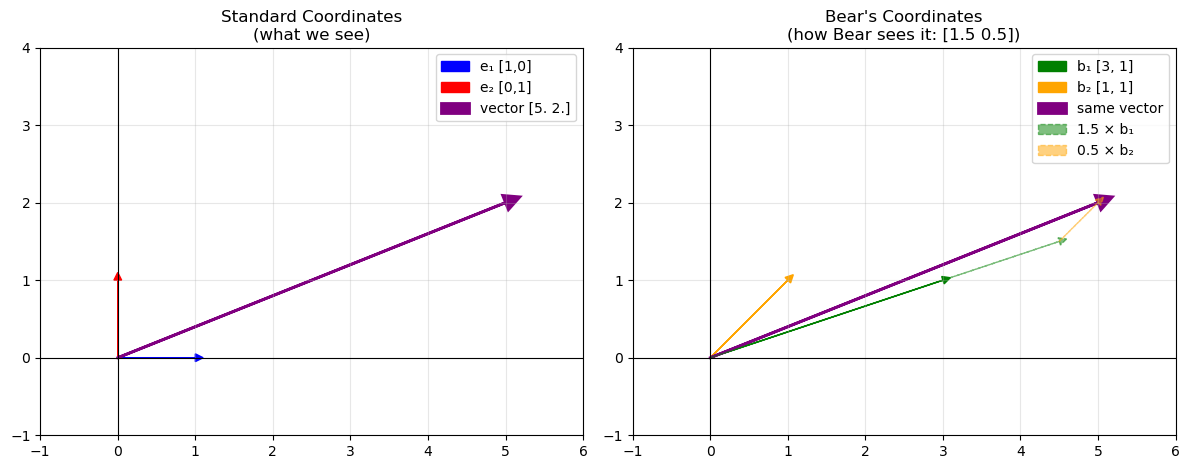

Same vector, two perspectives:
• Standard view: [5. 2.]
• Bear's view: [1.5 0.5]
• Bear says: '1.5 steps along my green direction + 0.5 steps along my orange direction'


In [9]:
# Let's visualize what's happening!
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: Standard basis
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.axvline(0, color='black', linewidth=0.8)

# Draw standard basis vectors
ax1.arrow(0, 0, 1, 0, head_width=0.1, head_length=0.1, fc='blue', ec='blue', label='e₁ [1,0]')
ax1.arrow(0, 0, 0, 1, head_width=0.1, head_length=0.1, fc='red', ec='red', label='e₂ [0,1]')

# Draw our vector in world coordinates
ax1.arrow(0, 0, v_world[0], v_world[1], head_width=0.2, head_length=0.2, 
          fc='purple', ec='purple', linewidth=2, label=f'vector {v_world}')

ax1.set_xlim(-1, 6)
ax1.set_ylim(-1, 4)
ax1.set_title('Standard Coordinates\n(what we see)')
ax1.legend()

# Right plot: Bear's basis
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.axvline(0, color='black', linewidth=0.8)

# Draw Bear's basis vectors
ax2.arrow(0, 0, b1[0], b1[1], head_width=0.1, head_length=0.1, 
          fc='green', ec='green', label=f'b₁ {b1}')
ax2.arrow(0, 0, b2[0], b2[1], head_width=0.1, head_length=0.1, 
          fc='orange', ec='orange', label=f'b₂ {b2}')

# Draw the same vector (but show how Bear sees it)
ax2.arrow(0, 0, v_world[0], v_world[1], head_width=0.2, head_length=0.2, 
          fc='purple', ec='purple', linewidth=2, label=f'same vector')

# Show the decomposition
comp1 = v_bear[0] * np.array(b1)
comp2 = v_bear[1] * np.array(b2)
ax2.arrow(0, 0, comp1[0], comp1[1], head_width=0.1, head_length=0.1, 
          fc='green', ec='green', alpha=0.5, linestyle='--', 
          label=f'{v_bear[0]} × b₁')
ax2.arrow(comp1[0], comp1[1], comp2[0], comp2[1], head_width=0.1, head_length=0.1, 
          fc='orange', ec='orange', alpha=0.5, linestyle='--',
          label=f'{v_bear[1]} × b₂')

ax2.set_xlim(-1, 6)
ax2.set_ylim(-1, 4)
ax2.set_title(f'Bear\'s Coordinates\n(how Bear sees it: {v_bear})')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Same vector, two perspectives:")
print(f"• Standard view: {v_world}")  
print(f"• Bear's view: {v_bear}")
print(f"• Bear says: '{v_bear[0]} steps along my green direction + {v_bear[1]} steps along my orange direction'")

## Example 2 — An orthonormal basis (rotation)

**What makes this special?** An orthonormal basis has two magical properties:
1. **Orthogonal:** Basis vectors are perpendicular (90° angles)
2. **Normal:** Basis vectors have length 1 (unit vectors)

This is like having a coordinate system that's just a **rotated version** of the standard x,y axes!

**Bear's New Basis Vectors** (still in our standard coordinates):
- `b₁ = (1/√2)[1, 1]` - "Go northeast at 45°, distance 1"
- `b₂ = (1/√2)[-1, 1]` - "Go northwest at 135°, distance 1"

Notice:
- Both vectors have length 1: `|b₁| = |b₂| = 1`
- They're perpendicular: `b₁ · b₂ = 0`
- The basis matrix is: `B = (1/√2) [[1, -1], [1, 1]]`

**The Magic:** For orthonormal bases, `B⁻¹ = Bᵀ` and projections work perfectly!

In [10]:
# Create Bear's orthonormal basis (45° rotation)
sqrt2 = np.sqrt(2)
b1_ortho = np.array([1, 1]) / sqrt2   # Northeast unit vector
b2_ortho = np.array([-1, 1]) / sqrt2  # Northwest unit vector

B_ortho = basis_matrix(b1_ortho, b2_ortho)

print("Bear's orthonormal basis matrix B:")
print(B_ortho)
print()

# Verify it's orthonormal
print("Is this basis orthonormal?", is_orthonormal(B_ortho))
print("Determinant (should be ±1 for orthonormal):", np.linalg.det(B_ortho))
print()

# Check that B^T = B^(-1) for orthonormal matrices
B_transpose = B_ortho.T
B_inverse = np.linalg.inv(B_ortho)
print("B^T equals B^(-1)?", np.allclose(B_transpose, B_inverse))
print("B^T @ B equals identity?", np.allclose(B_ortho.T @ B_ortho, np.eye(2)))
print()

# Vector in Bear's coordinates
v_bear_ortho = np.array([2.0, 1.0])
print("Vector in Bear's orthonormal coordinates:", v_bear_ortho)

# Convert to world coordinates
v_world_ortho = to_world(B_ortho, v_bear_ortho)
print("Same vector in world coordinates:", v_world_ortho)

Bear's orthonormal basis matrix B:
[[ 0.7071 -0.7071]
 [ 0.7071  0.7071]]

Is this basis orthonormal? True
Determinant (should be ±1 for orthonormal): 0.9999999999999999

B^T equals B^(-1)? True
B^T @ B equals identity? True

Vector in Bear's orthonormal coordinates: [2. 1.]
Same vector in world coordinates: [0.7071 2.1213]


**The Orthonormal Advantage:**

Because `B` is orthonormal, we have the beautiful property that `B⁻¹ = Bᵀ` (inverse equals transpose). This means we can convert coordinates in **two equivalent ways**:

**Method 1 (Matrix inverse):** `v_Bear = B⁻¹ @ v_world`
**Method 2 (Transpose):** `v_Bear = Bᵀ @ v_world`  
**Method 3 (Projections):** Each coordinate is `cᵢ = ⟨v_world, bᵢ⟩` (dot product with basis vector)

All three methods give the **same answer** for orthonormal bases! Let's verify:

In [12]:
# Method 1: Using matrix inverse
v_bear_method1 = to_basis(B_ortho, v_world_ortho)

# Method 2: Using transpose (equivalent to inverse for orthonormal)
v_bear_method2 = B_ortho.T @ v_world_ortho

# Method 3: Using projections (dot products)
v_bear_method3 = coords_by_projection(B_ortho, v_world_ortho)

print("Original Bear coordinates:", v_bear_ortho)
print("World coordinates:", v_world_ortho)
print()
print("Converting back to Bear coordinates:")
print("Method 1 (inverse):    ", v_bear_method1)
print("Method 2 (transpose):  ", v_bear_method2)
print("Method 3 (projections):", v_bear_method3)
print()
print("All methods agree?", np.allclose([v_bear_method1, v_bear_method2, v_bear_method3], v_bear_ortho))

# Let's also verify the projection calculation manually
print("\nManual projection verification:")
coord1 = np.dot(v_world_ortho, b1_ortho)  # projection onto first basis vector
coord2 = np.dot(v_world_ortho, b2_ortho)  # projection onto second basis vector
print(f"Coordinate along b₁: {coord1:.4f}")
print(f"Coordinate along b₂: {coord2:.4f}")
print(f"Manual projections: [{coord1:.4f}, {coord2:.4f}]")
print(f"Should equal: {v_bear_ortho}")

Original Bear coordinates: [2. 1.]
World coordinates: [0.7071 2.1213]

Converting back to Bear coordinates:
Method 1 (inverse):     [2. 1.]
Method 2 (transpose):   [2. 1.]
Method 3 (projections): [2. 1.]

All methods agree? True

Manual projection verification:
Coordinate along b₁: 2.0000
Coordinate along b₂: 1.0000
Manual projections: [2.0000, 1.0000]
Should equal: [2. 1.]


## Why Projections Fail for Non-Orthogonal Bases 🤔

**The Problem:** When basis vectors aren't perpendicular, projecting onto one vector picks up "shadow contributions" from the other vectors.

**Analogy:** Imagine trying to measure your height by looking at your shadow on the ground. If the sun is directly overhead (like an orthogonal basis), your shadow length equals your height. But if the sun is at an angle (like a non-orthogonal basis), your shadow is longer or shorter than your actual height!

**Mathematical reason:** Projections assume that basis vectors are independent (orthogonal). When they're not, there's "cross-talk" between the coordinates.

Let's see this failure in action:

In [13]:
# Let's see what happens when we try projections on the non-orthogonal basis
print("🚫 Attempting projections on non-orthogonal basis (THIS IS WRONG!):")
print("="*60)

# The wrong way: trying to use projections
b1_non = B_nonortho[:, 0]  # First basis vector [3, 1]
b2_non = B_nonortho[:, 1]  # Second basis vector [1, 1]

# Calculate "coordinates" using projections (wrong for non-orthogonal basis)
wrong_coord1 = np.dot(v_world, b1_non)  # This is NOT the right coordinate!
wrong_coord2 = np.dot(v_world, b2_non)  # This is NOT the right coordinate!

print(f"Vector in world coordinates: {v_world}")
print(f"Correct Bear coordinates: {v_bear}")
print()
print(f"Wrong 'coordinate 1' (projection): {wrong_coord1:.4f}")
print(f"Wrong 'coordinate 2' (projection): {wrong_coord2:.4f}")
print(f"Wrong answer: [{wrong_coord1:.4f}, {wrong_coord2:.4f}]")
print()
print(f"Error in coordinate 1: {abs(wrong_coord1 - v_bear[0]):.4f}")
print(f"Error in coordinate 2: {abs(wrong_coord2 - v_bear[1]):.4f}")

# Show why our helper function refuses to do this
print("\n" + "✅ Our helper function correctly refuses:")
try:
    coords_by_projection(B_nonortho, v_world)
except ValueError as e:
    print(f"Error: {e}")

print("\n💡 Remember: Only use projections for orthonormal bases!")

🚫 Attempting projections on non-orthogonal basis (THIS IS WRONG!):
Vector in world coordinates: [5. 2.]
Correct Bear coordinates: [1.5 0.5]

Wrong 'coordinate 1' (projection): 17.0000
Wrong 'coordinate 2' (projection): 7.0000
Wrong answer: [17.0000, 7.0000]

Error in coordinate 1: 15.5000
Error in coordinate 2: 6.5000

✅ Our helper function correctly refuses:
Error: Projection method requires an orthonormal basis. Use to_basis() for general bases.

💡 Remember: Only use projections for orthonormal bases!



## (Optional) Geometric intuition with a quick plot

Run the next cell to visualize the two bases and the same geometric vector in each coordinate system.


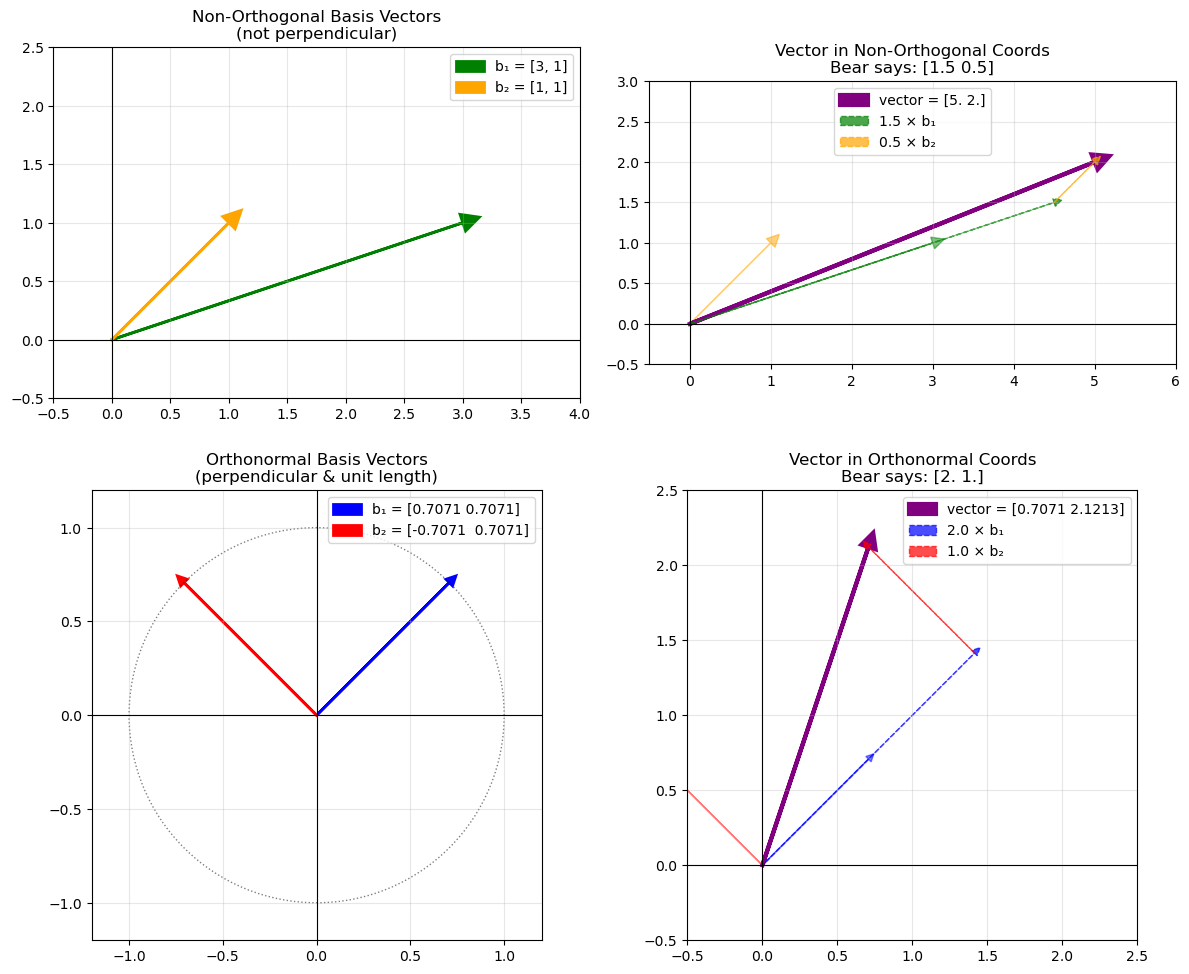

🎯 Key Takeaways from the Visualization:
• Top row: Non-orthogonal basis requires matrix inverse
• Bottom row: Orthonormal basis allows simple projections
• Same geometric vectors, different coordinate representations!


In [14]:
def plot_basis_transformation_comparison():
    """Create a comprehensive visualization showing both basis examples."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # === TOP ROW: Non-orthogonal basis ===
    
    # Plot 1: Non-orthogonal basis vectors
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.axvline(0, color='black', linewidth=0.8)
    
    # Draw basis vectors
    ax1.arrow(0, 0, b1[0], b1[1], head_width=0.15, head_length=0.15, 
              fc='green', ec='green', linewidth=2, label=f'b₁ = {b1}')
    ax1.arrow(0, 0, b2[0], b2[1], head_width=0.15, head_length=0.15, 
              fc='orange', ec='orange', linewidth=2, label=f'b₂ = {b2}')
    
    ax1.set_xlim(-0.5, 4)
    ax1.set_ylim(-0.5, 2.5)
    ax1.set_title('Non-Orthogonal Basis Vectors\n(not perpendicular)')
    ax1.legend()
    
    # Plot 2: Vector in non-orthogonal system
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linewidth=0.8)
    ax2.axvline(0, color='black', linewidth=0.8)
    
    # Draw basis vectors
    ax2.arrow(0, 0, b1[0], b1[1], head_width=0.15, head_length=0.15, 
              fc='green', ec='green', alpha=0.5)
    ax2.arrow(0, 0, b2[0], b2[1], head_width=0.15, head_length=0.15, 
              fc='orange', ec='orange', alpha=0.5)
    
    # Draw the vector and its components
    ax2.arrow(0, 0, v_world[0], v_world[1], head_width=0.2, head_length=0.2, 
              fc='purple', ec='purple', linewidth=3, label=f'vector = {v_world}')
    
    # Show the linear combination
    comp1 = v_bear[0] * np.array(b1)
    comp2 = v_bear[1] * np.array(b2)
    ax2.arrow(0, 0, comp1[0], comp1[1], head_width=0.1, head_length=0.1, 
              fc='green', ec='green', linestyle='--', alpha=0.7,
              label=f'{v_bear[0]:.1f} × b₁')
    ax2.arrow(comp1[0], comp1[1], comp2[0], comp2[1], head_width=0.1, head_length=0.1, 
              fc='orange', ec='orange', linestyle='--', alpha=0.7,
              label=f'{v_bear[1]:.1f} × b₂')
    
    ax2.set_xlim(-0.5, 6)
    ax2.set_ylim(-0.5, 3)
    ax2.set_title(f'Vector in Non-Orthogonal Coords\nBear says: {v_bear}')
    ax2.legend()
    
    # === BOTTOM ROW: Orthonormal basis ===
    
    # Plot 3: Orthonormal basis vectors  
    ax3.set_aspect('equal')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='black', linewidth=0.8)
    ax3.axvline(0, color='black', linewidth=0.8)
    
    # Draw orthonormal basis vectors
    ax3.arrow(0, 0, b1_ortho[0], b1_ortho[1], head_width=0.05, head_length=0.05, 
              fc='blue', ec='blue', linewidth=2, label=f'b₁ = {b1_ortho}')
    ax3.arrow(0, 0, b2_ortho[0], b2_ortho[1], head_width=0.05, head_length=0.05, 
              fc='red', ec='red', linewidth=2, label=f'b₂ = {b2_ortho}')
    
    # Draw circles to show unit length
    circle = plt.Circle((0, 0), 1, fill=False, linestyle=':', alpha=0.5)
    ax3.add_patch(circle)
    
    ax3.set_xlim(-1.2, 1.2)
    ax3.set_ylim(-1.2, 1.2)
    ax3.set_title('Orthonormal Basis Vectors\n(perpendicular & unit length)')
    ax3.legend()
    
    # Plot 4: Vector in orthonormal system
    ax4.set_aspect('equal')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(0, color='black', linewidth=0.8)
    ax4.axvline(0, color='black', linewidth=0.8)
    
    # Draw basis vectors
    ax4.arrow(0, 0, b1_ortho[0], b1_ortho[1], head_width=0.05, head_length=0.05, 
              fc='blue', ec='blue', alpha=0.5)
    ax4.arrow(0, 0, b2_ortho[0], b2_ortho[1], head_width=0.05, head_length=0.05, 
              fc='red', ec='red', alpha=0.5)
    
    # Draw the vector and its components
    ax4.arrow(0, 0, v_world_ortho[0], v_world_ortho[1], head_width=0.1, head_length=0.1, 
              fc='purple', ec='purple', linewidth=3, label=f'vector = {v_world_ortho}')
    
    # Show the linear combination
    comp1_ortho = v_bear_ortho[0] * b1_ortho
    comp2_ortho = v_bear_ortho[1] * b2_ortho
    ax4.arrow(0, 0, comp1_ortho[0], comp1_ortho[1], head_width=0.05, head_length=0.05, 
              fc='blue', ec='blue', linestyle='--', alpha=0.7,
              label=f'{v_bear_ortho[0]:.1f} × b₁')
    ax4.arrow(comp1_ortho[0], comp1_ortho[1], comp2_ortho[0], comp2_ortho[1], 
              head_width=0.05, head_length=0.05, 
              fc='red', ec='red', linestyle='--', alpha=0.7,
              label=f'{v_bear_ortho[1]:.1f} × b₂')
    
    ax4.set_xlim(-0.5, 2.5)
    ax4.set_ylim(-0.5, 2.5)
    ax4.set_title(f'Vector in Orthonormal Coords\nBear says: {v_bear_ortho}')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Create the comprehensive visualization
plot_basis_transformation_comparison()

print("🎯 Key Takeaways from the Visualization:")
print("• Top row: Non-orthogonal basis requires matrix inverse")
print("• Bottom row: Orthonormal basis allows simple projections")
print("• Same geometric vectors, different coordinate representations!")

## 🎯 Practice Exercises

**Goal:** Solidify your understanding by working through these problems step-by-step.

### Exercise 1: Non-Orthogonal Transformation (Warm-up)
Given basis matrix `B = [[2, 1], [1, 1]]` and Bear's coordinates `v_Bear = [1, 2]`:

**Part A:** Calculate the world coordinates `v_world = B @ v_Bear`  
**Part B:** Verify by recovering `v_Bear` from `v_world` using `B⁻¹`  
**Part C:** Try (incorrect) projections and see how much they're off by

### Exercise 2: Orthonormal Magic
Given orthonormal basis `B = (1/√2) * [[1, -1], [1, 1]]` and world vector `v_world = (1/√2) * [4, 2]`:

**Part A:** Use projections (dot products) to find Bear's coordinates  
**Part B:** Verify your answer using `B^T @ v_world`  
**Part C:** Double-check using the matrix inverse method

### Exercise 3: Understanding the Failure
**Challenge:** Explain in your own words why projections fail for non-orthogonal bases. Use the geometric "shadow" analogy.

---
**💡 Hints:**
- For orthonormal bases: `B⁻¹ = B^T` and projections work
- For general bases: Must use `B⁻¹`, projections give wrong answers
- Check your work with round-trip transformations!

In [15]:
# ========================================
# EXERCISE 1: Non-Orthogonal Transformation
# ========================================

print("🎯 EXERCISE 1: Non-Orthogonal Basis")
print("="*50)

# Setup
B_ex1 = np.array([[2., 1.],
                  [1., 1.]])
v_bear_ex1 = np.array([1., 2.])

print(f"Given basis B = \n{B_ex1}")
print(f"Bear's coordinates: {v_bear_ex1}")
print()

# Part A: Convert to world coordinates
print("Part A: Convert to world coordinates")
v_world_ex1 = B_ex1 @ v_bear_ex1
print(f"v_world = B @ v_bear = {v_world_ex1}")
print(f"Manual check: 1×[2,1] + 2×[1,1] = [2,1] + [2,2] = [4,3] ✓")
print()

# Part B: Convert back using inverse
print("Part B: Convert back using inverse")
v_bear_recovered_ex1 = np.linalg.solve(B_ex1, v_world_ex1)  # More numerically stable than inv
print(f"v_bear_recovered = B⁻¹ @ v_world = {v_bear_recovered_ex1}")
print(f"Round-trip successful? {np.allclose(v_bear_ex1, v_bear_recovered_ex1)}")
print()

# Part C: Show projection failure
print("Part C: Projection failure demonstration")
wrong_projections = B_ex1.T @ v_world_ex1
print(f"Wrong projections: B^T @ v_world = {wrong_projections}")
print(f"Correct answer: {v_bear_ex1}")
print(f"Error magnitude: {np.linalg.norm(wrong_projections - v_bear_ex1):.4f}")
print()

# ========================================
# EXERCISE 2: Orthonormal Magic
# ========================================

print("🎯 EXERCISE 2: Orthonormal Basis")
print("="*50)

# Setup
sqrt2 = np.sqrt(2)
B_ex2 = (1/sqrt2) * np.array([[1., -1.],
                              [1.,  1.]])
v_world_ex2 = (1/sqrt2) * np.array([4., 2.])

print(f"Given orthonormal basis B = \n{B_ex2}")
print(f"World coordinates: {v_world_ex2}")
print(f"Is orthonormal? {is_orthonormal(B_ex2)}")
print()

# Part A: Use projections
print("Part A: Find coordinates using projections")
b1_ex2 = B_ex2[:, 0]
b2_ex2 = B_ex2[:, 1]
coord1_proj = np.dot(v_world_ex2, b1_ex2)
coord2_proj = np.dot(v_world_ex2, b2_ex2)
v_bear_projections = np.array([coord1_proj, coord2_proj])
print(f"Projection onto b₁: {coord1_proj:.4f}")
print(f"Projection onto b₂: {coord2_proj:.4f}")
print(f"Bear coordinates (projections): {v_bear_projections}")
print()

# Part B: Verify with transpose
print("Part B: Verify using B^T")
v_bear_transpose = B_ex2.T @ v_world_ex2
print(f"Bear coordinates (B^T method): {v_bear_transpose}")
print(f"Projections match transpose? {np.allclose(v_bear_projections, v_bear_transpose)}")
print()

# Part C: Double-check with inverse
print("Part C: Double-check with inverse")
v_bear_inverse = np.linalg.solve(B_ex2, v_world_ex2)
print(f"Bear coordinates (inverse method): {v_bear_inverse}")
print(f"All three methods agree? {np.allclose([v_bear_projections, v_bear_transpose, v_bear_inverse], v_bear_projections)}")
print()

# ========================================
# EXERCISE 3: Conceptual Understanding
# ========================================

print("🎯 EXERCISE 3: Why Projections Fail")
print("="*50)
print("Think about this:")
print("• When basis vectors are orthogonal (perpendicular), projecting onto")
print("  one vector doesn't 'see' the other vector at all")
print("• When basis vectors are NOT orthogonal, projecting onto one vector")
print("  picks up 'shadow contributions' from the other vector")
print("• It's like measuring your height from a tilted shadow - you get")
print("  the wrong answer unless the light source is directly overhead!")
print()
print("Mathematical reason: Projections assume orthogonality.")
print("When that assumption breaks, the method fails.")

🎯 EXERCISE 1: Non-Orthogonal Basis
Given basis B = 
[[2. 1.]
 [1. 1.]]
Bear's coordinates: [1. 2.]

Part A: Convert to world coordinates
v_world = B @ v_bear = [4. 3.]
Manual check: 1×[2,1] + 2×[1,1] = [2,1] + [2,2] = [4,3] ✓

Part B: Convert back using inverse
v_bear_recovered = B⁻¹ @ v_world = [1. 2.]
Round-trip successful? True

Part C: Projection failure demonstration
Wrong projections: B^T @ v_world = [11.  7.]
Correct answer: [1. 2.]
Error magnitude: 11.1803

🎯 EXERCISE 2: Orthonormal Basis
Given orthonormal basis B = 
[[ 0.7071 -0.7071]
 [ 0.7071  0.7071]]
World coordinates: [2.8284 1.4142]
Is orthonormal? True

Part A: Find coordinates using projections
Projection onto b₁: 3.0000
Projection onto b₂: -1.0000
Bear coordinates (projections): [ 3. -1.]

Part B: Verify using B^T
Bear coordinates (B^T method): [ 3. -1.]
Projections match transpose? True

Part C: Double-check with inverse
Bear coordinates (inverse method): [ 3. -1.]
All three methods agree? True

🎯 EXERCISE 3: Why Pro


## ✅ Solutions (expand to reveal)

<details>
<summary>Exercise 1 Solution</summary>

**Part A:** $v_{\text{world}} = B \cdot v_{\text{Bear}} = \begin{bmatrix}2 & 1\\1 & 1\end{bmatrix} \begin{bmatrix}1\\2\end{bmatrix} = \begin{bmatrix}4\\3\end{bmatrix}$

**Part B:** $B^{-1} = \begin{bmatrix}1 & -1\\-1 & 2\end{bmatrix}$, so $v_{\text{Bear}} = B^{-1} v_{\text{world}} = \begin{bmatrix}1\\2\end{bmatrix}$ ✓

**Part C:** Projections give $[11, 7]$ instead of $[1, 2]$ - significant error!

</details>

<details>
<summary>Exercise 2 Solution</summary>

**Part A:** Using projections: $v_{\text{Bear}} = [3, -1]$

**Part B:** Using transpose: $v_{\text{Bear}} = B^T v_{\text{world}} = [3, -1]$ ✓

**Part C:** Using inverse: $v_{\text{Bear}} = B^{-1} v_{\text{world}} = [3, -1]$ ✓

All three methods agree because the basis is orthonormal!

</details>

<details>
<summary>Exercise 3 Solution</summary>

**Why projections fail for non-orthogonal bases:**

Projections assume that basis vectors are orthogonal (perpendicular). When they're not:
- Projecting onto one basis vector picks up "shadow contributions" from other vectors
- Like measuring height from a tilted shadow - you get the wrong measurement unless the light is directly overhead
- Mathematically: projections assume $B^T B = I$, which only holds for orthonormal bases

For non-orthogonal bases, you **must** use the matrix inverse $B^{-1}$ to get correct coordinates.

</details>


## 🎓 Summary & Key Takeaways

### The Big Picture
**Changing basis** = converting coordinates between different coordinate systems. It's like translating between different languages for describing the same geometric object.

### The Fundamental Rules

| Type of Basis | Forward Transform | Backward Transform | Projection Method |
|---------------|-------------------|-------------------|-------------------|
| **General basis** | `v_world = B @ v_basis` | `v_basis = B⁻¹ @ v_world` | ❌ **Fails** |
| **Orthonormal basis** | `v_world = B @ v_basis` | `v_basis = B^T @ v_world` | ✅ **Works** |

### Key Insights

1. **Matrix Columns = Basis Vectors:** Build basis matrix `B` by stacking basis vectors as columns

2. **Two-Way Street:** 
   - Basis → World: multiply by `B`
   - World → Basis: multiply by `B⁻¹` (or `B^T` if orthonormal)

3. **Orthonormal is Special:** When basis vectors are perpendicular and unit length:
   - `B⁻¹ = B^T` (inverse equals transpose)
   - Projections (dot products) give coordinates directly
   - Geometric rotations are orthonormal transformations

4. **When Projections Fail:** For non-orthogonal bases, projections pick up "cross-talk" between coordinates

### Real-World Applications
- **Computer Graphics:** Rotating objects, changing camera viewpoints
- **Machine Learning:** Principal Component Analysis (PCA), feature transformations
- **Robotics:** Converting between different coordinate frames
- **Physics:** Changing reference frames in mechanics

### Pro Tips
- ✅ Always verify with round-trip transformations
- ✅ Check if your basis is orthonormal using `B^T @ B = I`
- ⚠️ Use `np.linalg.solve()` instead of computing inverses explicitly
- 🚫 Never use projections for non-orthogonal bases!

## 🌟 Real-World Connection: Where You'll See This

**Example: Data Science & PCA**
When you have data with correlated features (like height and weight), PCA finds a new orthonormal basis where:
- First axis captures maximum variance
- Second axis captures remaining variance, perpendicular to first
- You transform data from original coordinates to PCA coordinates using basis change!

**Example: Computer Graphics**
When you rotate a 3D object in a game:
- Object has coordinates in its "local space" 
- You transform to "world space" coordinates using rotation matrices
- These rotation matrices are orthonormal (preserving lengths and angles)

**Example: GPS Navigation**
Your phone converts between:
- Latitude/longitude coordinates (spherical)
- Local map coordinates (Cartesian)
- Screen pixel coordinates

Each conversion is a basis change, helping the same location data work in different coordinate systems.

**The Math is the Same:** All these applications use the principles you just learned!